This compares model size and number of predictions for different model creation options and datasets.
I should really merge this into the dataset evaluation, but that will require changing the JSON export to include unconfirmed trips, and I just want to get this done now.

It assumes that the datasets are loaded into separate docker containers with ports exposed at 27071, 27018 and 27019.
It requires re-introduction of a **hack** 
https://github.com/e-mission/e-mission-server/commit/4cf770e3e30af617b89f9fe6007298afc37c0dd6
to allow re-loading of database connections


TODO: Clean this up later after cleaning up the export code

In [1]:
import pandas as pd
import numpy as np
import logging

In [2]:
import emission.core.get_database as edb

storage not configured, falling back to sample, default configuration
Connecting to database URL localhost


In [3]:
import matplotlib.pyplot as plt

In [4]:
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq

In [5]:
import emission.analysis.modelling.tour_model.data_preprocessing as old_preprocess
import emission.analysis.modelling.tour_model_first_only.data_preprocessing as new_preprocess

import emission.analysis.modelling.tour_model.get_users as old_users
import emission.analysis.modelling.tour_model_first_only.get_users as new_users

import emission.analysis.modelling.tour_model.evaluation_pipeline as old_ep
import emission.analysis.modelling.tour_model_first_only.evaluation_pipeline as new_ep

import emission.analysis.modelling.tour_model.load_predict as old_lp
import emission.analysis.modelling.tour_model_first_only.load_predict as new_lp

In [6]:
import emission.analysis.modelling.tour_model.label_processing as lp

In [7]:
# Let's just return a random split since their lengths should be roughly equal
# and that way we don't have to run the evaluation pipeline first
# and spend hours on it
# Copied version to allow us to override old implementation on the fly :)
def find_best_split_and_parameters(user,test_data):
    import random
    # find a random score
    best_split_idx = random.choice(range(len(test_data)))
    # use the position of best_score to find best_split
    best_split = test_data[best_split_idx]
    # use best_split_idx to find the best parameters
    low = best_split_idx * 100
    dist_pct = best_split_idx / 100
    return best_split,best_split_idx,low,dist_pct

In [8]:
def create_location_map(trip_list, bins):
    bin_loc_feat = {}
    user_input_map = {}
    for i, curr_bin in enumerate(bins):
        # print(f"Considering {curr_bin} for trip list of length {len(trip_list)}")
        bin_trips = [trip_list[j] for j in curr_bin]
        # print(f"Considering {bin_trips} for bin {curr_bin}")
        x = old_preprocess.extract_features(bin_trips)
        bin_loc_feat[str(i)] = [feat[0:4] for feat in x]
    return bin_loc_feat

In [9]:
def create_user_input_map(trip_list, bins):
    # map from bin index to user input probabilities
    # e.g. {"0": [{'labels': {'mode_confirm': 'drove_alone', 'purpose_confirm': 'work', 'replaced_mode': 'drove_alone'}, 'p': 1.0}]}
    user_input_map = {}
    for b, curr_bin in enumerate(bins):
        bin_trips = [trip_list[j] for j in curr_bin]
        user_label_df = pd.DataFrame([trip['data']['user_input'] for trip in bin_trips])
        # user_label_df = lp.map_labels(user_label_df)
        # compute the sum of trips in this cluster
        sum_trips = len(user_label_df)
        # compute unique label sets and their probabilities in one cluster
        # 'p' refers to probability
        unique_labels = user_label_df.groupby(user_label_df.columns.tolist()).size().reset_index(name='uniqcount')
        unique_labels['p'] = unique_labels.uniqcount / sum_trips
        labels_columns = user_label_df.columns.to_list()
        bin_label_combo_list = []
        for i in range(len(unique_labels)):
            one_set_labels = {}
            # e.g. labels_only={'mode_confirm': 'pilot_ebike', 'purpose_confirm': 'work', 'replaced_mode': 'walk'}
            labels_only = {column: unique_labels.iloc[i][column] for column in labels_columns}
            one_set_labels["labels"] = labels_only
            one_set_labels['p'] = unique_labels.iloc[i]['p']
            # e.g. one_set_labels = {'labels': {'mode_confirm': 'walk', 'replaced_mode': 'walk', 'purpose_confirm': 'exercise'}, 'p': 1.0}
            bin_label_combo_list.append(one_set_labels)
        user_input_map[str(b)] = bin_label_combo_list
    return user_input_map

In [10]:
def find_bin(trip, bin_locations, radius):
    trip_feat = new_preprocess.extract_features([trip])[0]
    trip_loc_feat = trip_feat[0:4]
    first_round_label_set = list(bin_locations.keys())
    sel_fl = None
    for fl in first_round_label_set:
        # extract location features of selected bin
        sel_loc_feat = bin_locations[fl]
        # Check if start/end locations of the new trip and every start/end locations in this bin are within the range of
        # radius. If so, the new trip falls in this bin. Then predict the second round label of the new trip
        # using this bin's model
        if old_lp.in_bin(sel_loc_feat, trip_loc_feat, radius):
            sel_fl = fl
            break
    if not sel_fl:
        logging.debug(f"sel_fl = {sel_fl}, early return")
        return -1
    return sel_fl

In [11]:
def get_dataset_stats(program, uuid_list):
    curr_dataset_validity_stats = []
    for u in uuid_list:
        curr_validity_stats = {"program": program, "user_id": u}
        trips = old_preprocess.read_data(u)
        # print([t for t in trips if "user_input" not in t["data"]])
        unlabeled_trips = [t for t in trips if t["data"]["user_input"] == {}]
        print(f"For {u} in {program}, read {len(trips)}")
        curr_validity_stats["all_trip_count_old"] = len(trips)
        curr_validity_stats["unlabeled_trip_count_old"] = len(unlabeled_trips)
        filter_trips = old_preprocess.filter_data(trips, 100)
        curr_validity_stats["valid_trip_count_old"] = len(filter_trips)
        curr_validity_stats["valid_user_old"] = old_users.valid_user(filter_trips, trips)
        if old_users.valid_user(filter_trips, trips):
            tune_idx, test_idx = old_preprocess.split_data(filter_trips)
            test_data = old_preprocess.get_subdata(filter_trips, tune_idx)
            best_split, best_split_idx, low, dist_pct = find_best_split_and_parameters(u,test_data)
            sim, bins, bin_trips, filter_trips = old_ep.first_round(best_split, 100)
            curr_validity_stats["bins_old"] = len(bins)
            curr_validity_stats["bin_trips_old"] = len(bin_trips)
            curr_validity_stats["model_input_trips_old"] = len(bin_trips)
            print(f"Creating model maps for {bins} and {len(bin_trips)}")
            bin_loc_feat = create_location_map(filter_trips, bins)
            user_input_map = create_user_input_map(filter_trips, bins)
            pred_bin_list = [find_bin(t, bin_loc_feat, 100) for t in trips]
            print(f"Found old predicted bins {pred_bin_list}")
            curr_validity_stats["predicted_trips_all_old"] = np.count_nonzero(pd.Series(pred_bin_list) != -1)
            pred_bin_list = [find_bin(t, bin_loc_feat, 100) for t in unlabeled_trips]
            print(f"Found old unlabeled predicted bins {pred_bin_list}")
            curr_validity_stats["predicted_trips_unlabeled_old"] = np.count_nonzero(pd.Series(pred_bin_list) != -1)
            user_input_pred_list = [user_input_map[pb] for pb in pred_bin_list if pb != -1]
            # print(f"User predictions for unlabeled trips are {user_input_pred_list}")
        else:
            curr_validity_stats["bins_old"] = 0
            curr_validity_stats["bin_trips_old"] = 0
            curr_validity_stats["model_input_trips_old"] = 0

        # print(f"Finished iterating over old, starting with new....")
        trips = new_preprocess.read_data(u)
        unlabeled_trips = [t for t in trips if t["data"]["user_input"] == {}]

        curr_validity_stats["all_trip_count_new"] = len(trips)
        curr_validity_stats["unlabeled_trip_count_new"] = len(unlabeled_trips)
        filter_trips = new_preprocess.filter_data(trips, 500)
        curr_validity_stats["valid_trip_count_new"] = len(filter_trips)
        curr_validity_stats["valid_user_new"] = new_users.valid_user(filter_trips, trips)
        sim, bins, bin_trips, filter_trips = new_ep.first_round(filter_trips, 500)
        curr_validity_stats["bins_new"] = len(bins)
        curr_validity_stats["bin_trips_new"] = len(bin_trips)
        curr_validity_stats["model_input_trips_new"] = len(bin_trips)
        print(f"Creating model maps for {len(bin_trips)}")
        bin_loc_feat = create_location_map(filter_trips, bins)
        user_input_map = create_user_input_map(filter_trips, bins)
        pred_bin_list = [find_bin(t, bin_loc_feat, 500) for t in trips]
        print(f"Found new predicted bins {pred_bin_list}")
        curr_validity_stats["predicted_trips_all_new"] = np.count_nonzero(pd.Series(pred_bin_list) != -1)
        pred_bin_list = [find_bin(t, bin_loc_feat, 500) for t in filter_trips]
        assert len(pred_bin_list) == len(filter_trips)
        pred_bin_list = [find_bin(t, bin_loc_feat, 500) for t in unlabeled_trips]
        print(f"Found new unlabeled predicted bins {pred_bin_list}")
        curr_validity_stats["predicted_trips_unlabeled_new"] = np.count_nonzero(pd.Series(pred_bin_list) != -1)

        curr_dataset_validity_stats.append(curr_validity_stats)
    return curr_dataset_validity_stats

In [12]:
model_validity_stats = []

In [13]:
model_validity_stats = model_validity_stats + get_dataset_stats("minipilot", esta.TimeSeries.get_uuid_list())

For 576e37c7-ab7e-4c03-add7-02486bc3f42e in minipilot, read 237
in ep: after filtering, 165
in ep: after binning, 165
in ep: after deleting, 76
in ep: after assignment, 76
Creating model maps for [[1, 13, 19, 57, 61, 72, 92, 106, 109, 120, 129, 131, 136, 142, 148, 152, 160], [2, 14, 20, 27, 58, 93, 102, 110, 121, 130, 132, 134, 149, 153, 161], [31, 69, 86, 119, 141, 162], [68, 85, 98, 139, 151], [82, 95, 112, 147, 164], [12, 108, 117, 145], [55, 127, 158, 163], [91, 116, 128, 159], [113, 114, 133, 155], [0, 24, 83], [7, 18, 67], [10, 138, 150], [52, 118, 140]] and 76
Found old predicted bins [-1, -1, '9', -1, '0', '1', -1, -1, -1, -1, -1, '10', -1, -1, '11', -1, '5', '0', '1', -1, -1, -1, -1, '10', '0', '1', -1, -1, -1, -1, '9', -1, -1, '1', -1, -1, -1, -1, -1, '12', '2', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '12', '2', -1, -1, -1, '6', -1, -1, -1, '0', '1', -1, -1, -1, '0', -1, -1, -1, -1, -1, '10', '9', '3', '12', '2', -1, -1,

in ep: after filtering, 154
in ep: after binning, 154
in ep: after deleting, 81
in ep: after assignment, 81
Creating model maps for [[6, 10, 15, 21, 36, 40, 43, 44, 46, 49, 52, 57, 59, 64, 66, 77, 80, 84, 86, 88, 94, 101, 102, 106, 109, 112, 114, 117, 118, 120, 123, 125, 128, 130, 133, 134, 136, 146], [9, 11, 16, 20, 24, 32, 35, 45, 47, 48, 50, 58, 63, 65, 75, 81, 83, 85, 87, 103, 104, 110, 111, 113, 115, 119, 124, 126, 127, 135, 147, 150], [5, 14, 55, 69, 76, 122], [4, 13, 93, 99, 121]] and 81
Found old predicted bins [-1, -1, -1, -1, -1, '3', '2', -1, '0', -1, -1, '1', '0', '1', -1, '3', '2', '0', '1', -1, -1, -1, -1, -1, '1', '0', -1, -1, '1', -1, '0', -1, -1, -1, -1, -1, -1, -1, '1', '0', '1', -1, -1, -1, '1', '0', -1, -1, -1, -1, '0', '1', '0', -1, -1, '3', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', -1, -1, '0', -1, -1, '2', -1, -1, '0', '1', '0', -1, -1, -1, -1, '1', '0', -1, '1', -1, -1, '0', '3', -1, -1, -1, -1, '2', -1, -1, '1', -1, -1, -1, -1, -1, -1, '1', '2', '0', -1

Creating model maps for 163
Found new predicted bins ['19', '2', '0', '4', '2', '1', '20', '21', '7', '22', '8', '23', '24', '2', '5', '4', '9', '0', '1', '2', '12', '1', '7', '25', '26', '2', '0', '1', '2', '0', '1', '3', '0', '0', '13', '7', '27', '2', '0', '1', '14', '8', '28', '29', '30', '2', '1', '2', '5', '0', '1', '2', '0', '0', '1', '2', '1', '31', '32', '33', '34', '35', '36', '37', '38', '15', '5', '39', '16', '14', '8', '40', '16', '41', '42', '43', '44', '45', '46', '6', '2', '10', '13', '3', '17', '10', '1', '3', '5', '4', '3', '4', '47', '11', '48', '49', '50', '51', '52', '18', '53', '54', '55', '56', '3', '17', '4', '3', '0', '0', '0', '0', '0', '0', '1', '2', '0', '0', '0', '0', '0', '1', '2', '0', '0', '1', '57', '11', '6', '3', '10', '58', '12', '59', '60', '9', '0', '5', '61', '3', '0', '0', '62', '63', '64', '65', '66', '11', '18', '6', '67', '1', '5', '4', '6', '15', '0', '1', '6', '6', '2', '1', '6', -1, '6', '67', '1', '2', '0', '1', '2', '0', '4', '2', '1', '6

Found new unlabeled predicted bins ['4', '14', -1, -1, -1, '78', '3', '4', '4', -1, -1, -1, '201', -1, -1, -1, '158', '51', '78', '21', '78', '71', '107', '32', -1, '9', '21', '19', '13', '78', -1, -1, '19', '13', '13', '48', '39', '0', '1', '19', -1, '32', -1, -1, '39', '49', '132', '230', '1', '42', -1, '187', -1, -1, '51', -1, -1, '230', '253', '139', -1, -1, -1, -1, -1, -1, -1, -1, -1, '230', -1, '2', -1, -1, '230', -1, '256', -1, '57', -1, '138', '65', '215', '22', -1, -1, -1, -1, -1, -1, -1, '1', '0', '101', '219', '47', -1, -1, '39', '0']
For 898b1a5e-cdd4-4a0c-90e4-942fa298e456 in minipilot, read 274
in ep: after filtering, 194
in ep: after binning, 194
in ep: after deleting, 53
in ep: after assignment, 53
Creating model maps for [[68, 69, 90, 141, 143], [93, 96, 155, 184], [70, 91, 177], [103, 111, 189], [13, 160], [19, 26], [28, 32], [45, 63], [51, 56], [65, 144], [67, 142], [71, 119], [79, 132], [80, 176], [82, 175], [83, 88], [85, 178], [92, 154], [100, 102], [106, 188], [1

in ep: after filtering, 481
in ep: after binning, 481
in ep: after deleting, 99
in ep: after assignment, 99
Creating model maps for [[13, 16, 71, 77, 92, 113, 119, 128, 154, 161, 164, 179, 197, 206, 219, 233, 257, 265, 289, 324, 328, 359, 368, 392, 402, 407, 419, 434, 437, 440, 451, 455, 458, 463, 467, 473], [28, 56, 72, 78, 95, 123, 180, 204, 220, 230, 235, 305, 362, 405, 447, 450], [48, 168, 207, 213, 231, 325, 329, 344, 408], [89, 91, 127, 175, 288, 307, 358], [14, 37, 61, 394, 456], [35, 139, 172, 229, 364], [148, 314, 399, 423, 461], [17, 132, 347, 453], [45, 143, 223, 411], [116, 156, 431, 439], [232, 276, 330, 409]] and 99
Found old predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', '4', -1, -1, '0', -1, '7', -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, -1, -1, '5', -1, -1, '4', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '8', -1, -1, -1, -1, -1, '2', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, '4', -1, -1, -1, -1, 

In [14]:
esta.TimeSeries._reset_url("localhost:27018")

Connecting to new URL localhost:27018 resetting _current_db link
After changing URL, connection is Database(MongoClient(host=['localhost:27018'], document_class=dict, tz_aware=False, connect=True), 'Stage_database')
After resetting the timeseries connections, map is {<EntryType.DATA_TYPE: 0>: Collection(Database(MongoClient(host=['localhost:27018'], document_class=dict, tz_aware=False, connect=True), 'Stage_database'), 'Stage_timeseries'), <EntryType.ANALYSIS_TYPE: 1>: Collection(Database(MongoClient(host=['localhost:27018'], document_class=dict, tz_aware=False, connect=True), 'Stage_database'), 'Stage_analysis_timeseries')}


In [15]:
model_validity_stats = model_validity_stats + get_dataset_stats("nrel-lh", esta.TimeSeries.get_uuid_list())

For e7920e12-689d-4436-8b55-3c9fbcb4d395 in nrel-lh, read 200
Creating model maps for 40
Found new predicted bins ['2', '3', '6', '7', '0', '8', -1, '1', '12', '0', '0', '0', '0', '4', '5', -1, -1, '0', -1, -1, '9', '10', '0', -1, -1, -1, -1, '1', '12', -1, '11', -1, '22', -1, -1, '1', '12', '1', '12', -1, -1, '2', '3', '0', -1, -1, '0', -1, -1, -1, -1, '1', '12', -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '12', -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, '0', '1', '12', '0', '0', -1, -1, -1, -1, '0', '13', '14', '0', '0', -1, -1, -1, -1, -1, -1, -1, '2', '3', '0', '0', '1', -1, '12', '0', -1, -1, '0', '0', '0', '0', -1, -1, '0', '0', '0', -1, -1, '0', -1, -1, '0', '15', '16', '4', '5', '0', '4', '5', '0', '0', '2', '3', '17', '18', '19', '20', '21', '0', '22', '23', '24', '25', '26', -1, '0', '0', '1', -1, -1, -1, -1, -1, -1, -1, -1, '22', '23', '4', '5', -1, -1, -1, -1, -1, '0', '0', '0', '0', '0', '0', '0', -1, -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, '24', '25', '0', -1, -1, '0'

Creating model maps for 251
Found new predicted bins ['0', '0', '14', '32', '33', '15', '15', '34', '35', '16', '36', '37', '0', '2', '5', '0', '0', '38', '39', '8', '9', '0', '0', '0', '0', '2', '5', '0', '0', '0', '0', '0', '0', '0', '1', '6', '7', '0', '0', '0', '0', '0', '1', '7', '1', '3', '0', '3', '1', '3', '0', '0', '0', '0', '0', '4', '10', '0', '0', '0', '0', '0', '0', '1', '3', '6', '7', '3', '0', '0', '0', '6', '17', '0', '0', '0', '2', '0', '40', '41', '0', '0', '4', '10', '14', '18', '42', '19', '19', '43', '44', '45', '46', '18', '47', '16', '20', '21', '48', '49', '50', '22', '51', '52', '11', '23', '0', '0', '0', '0', '0', '6', '17', '0', '0', '0', '53', '54', '0', '55', '56', '57', '20', '58', '0', '12', '13', '0', '0', '4', '10', '0', '3', '1', '0', '1', '0', '2', '5', '0', '59', '60', '21', '61', '62', '63', '64', '22', '65', '66', '2', '2', '0', '0', '4', '4', '1', '12', '13', '0', '0', '4', '0', '67', '6', '7', '12', '13', '0', '0', '24', '24', '0', '0', '25', '26

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Creating model maps for 17
Found new predicted bins ['0', '1', '0', '2', -1, -1, '4', '5', -1, '1', '0', '2', -1, '6', '7', '8', '9', -1, -1, -1, '3', -1, -1, -1, -1, '1', '0', -1, -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, '10', '11', -1, -1, -1, -1, -1, -1, '3', -1, -1, -1, -1, '1', '0', -1, -1, -1, -1, -1, -1, -1, -1, '0', '3', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, -1, '0', -1, '1', -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, '1', '0', -1, -1, -1]
Found new unlabeled predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '0', -1, -1, -1, -

In [16]:
edb.get_profile_db().distinct("client")

['NRELlh']

In [17]:
esta.TimeSeries._reset_url("localhost:27019")

Connecting to new URL localhost:27019 resetting _current_db link
After changing URL, connection is Database(MongoClient(host=['localhost:27019'], document_class=dict, tz_aware=False, connect=True), 'Stage_database')
After resetting the timeseries connections, map is {<EntryType.DATA_TYPE: 0>: Collection(Database(MongoClient(host=['localhost:27019'], document_class=dict, tz_aware=False, connect=True), 'Stage_database'), 'Stage_timeseries'), <EntryType.ANALYSIS_TYPE: 1>: Collection(Database(MongoClient(host=['localhost:27019'], document_class=dict, tz_aware=False, connect=True), 'Stage_database'), 'Stage_analysis_timeseries')}


In [18]:
model_validity_stats = model_validity_stats + get_dataset_stats("stage", esta.TimeSeries.get_uuid_list())

For 9cfc3133-3505-4923-b6fb-feb0e50a5aba in stage, read 0
Creating model maps for 0
Found new predicted bins []
Found new unlabeled predicted bins []
For cc114670-ef99-4247-a3a2-47529247d8ac in stage, read 0
Creating model maps for 0
Found new predicted bins []
Found new unlabeled predicted bins []
For 2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea in stage, read 0
Creating model maps for 0
Found new predicted bins []
Found new unlabeled predicted bins []


/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Se

For b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82 in stage, read 40
Creating model maps for 22
Found new predicted bins ['1', '0', '0', '0', '0', '2', '3', '4', '5', '0', '0', '0', '0', '0', '0', '6', '7', '8', '9', '10', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '9', '10', '0', '0', '0', '0', '0', '0']
Found new unlabeled predicted bins ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '9', '10', '0', '0', '0', '0', '0', '0']
For d4376620-fbcd-4aab-95bf-8c2e0ecf9adf in stage, read 74
Creating model maps for 42
Found new predicted bins ['0', '0', '0', '0', '0', '3', '4', '1', '1', '1', '5', '6', '7', '8', '9', '10', '11', '2', '2', '2', '12', '13', '14', '15', '0', '0', '0', '0', '0', '16', '17', '18', '19', '20', '21', '22', '23', '0', '0', '0', -1, -1, -1, '0', '0', '0', '0', '0', '0', '0', '0', '0', '22', '23', '0', '0', '0', '0', '0', '0', -1, -1, '0', -1, -1, -1, -1, -1, '15', -1, -1, '0', '0', '0']
Found new unlabeled predicted bins ['0', -1, -1, -1, '0', '0', '0', '0',

For 93c6e0f1-56a4-4e07-b920-ded664419dc6 in stage, read 128
Creating model maps for 79
Found new predicted bins ['1', -1, '0', '6', '13', '1', '0', -1, -1, -1, '1', '0', '0', '1', '14', '15', '16', '17', '18', '19', '7', '7', '20', '21', '22', '4', '3', '4', '3', '23', '24', '25', '26', '27', '8', '2', '28', '9', '29', '10', '10', '3', '2', '0', '0', '1', '30', '4', '31', '0', '1', '2', '0', '0', -1, -1, '44', -1, '5', '32', '33', '34', '35', '8', '1', '36', '37', '38', '2', '0', '11', '39', '3', '2', '11', '40', '0', '1', '5', '9', '41', '1', '5', '9', '2', '42', '12', '43', -1, '40', '1', '5', -1, -1, '6', '7', '20', -1, -1, '2', '44', -1, -1, '5', '9', -1, -1, '2', '44', '45', '12', '43', '2', '43', '2', '1', '3', '3', -1, '2', '28', -1, -1, -1, -1, -1, -1, '1']
Found new unlabeled predicted bins [-1, '0', -1, -1, -1, '1', '2', '0', '0', -1, -1, '44', -1, '1', '5', '9', -1, '40', '1', -1, -1, '7', '20', -1, -1, '2', '44', -1, -1, '5', '9', -1, -1, '43', '43', '2', '1', '3', '3', -1,

For 29d04974-ff70-4c61-a0b0-dafcc1d23ec8 in stage, read 70
Creating model maps for 3
Found new predicted bins ['0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, -1, -1, '1', -1, '1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', '2', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, -1]
Found new unlabeled predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, -1, -1, -1, -1, -1, '1', -1, '1', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, -1]
For 0118ea1d-1a13-4e61-b99a-d68ac08e883f in stage, read 57
Creating model maps for 6
Found new predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, '0', '0', '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '1', -1, '2', '

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


For 1ac2dbad-b3cb-4597-89af-f4de4340b5f0 in stage, read 7
Creating model maps for 0
Found new predicted bins [-1, -1, -1, -1, -1, -1, -1]
Found new unlabeled predicted bins [-1, -1, -1, -1, -1, -1, -1]
For 9aa33ec1-c02d-437d-9b65-389e20beaa00 in stage, read 21
Creating model maps for 0
Found new predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Found new unlabeled predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
For 7ac4a17a-985f-46b4-9114-c139305aae29 in stage, read 239
Creating model maps for 1
Found new predicted bins ['0', -1, '0', -1, -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', -1, '0', -1, -1, '0', '0', -1, '0', -1, -1, '0', '0', -1, -1, -1, -1, -1, -1, -1, '0', -1, '0', -1, -1, -1, '0', '0', -1, -1, -1, -1, '0', -1, '0', -1, -1, -1, '0', -1, -1, -1, '0', -1, '0', -1, '0', -1, -1, -1, -1, '0', '0', -1, '0', '0', -1, -1, '0'

Found new predicted bins [-1, '1', '1', '1', -1, '1', '1', -1, -1, -1, -1, -1, '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', -1, '0', '0', '0', '1', '0', -1, -1, -1, '1', '0', '0', '0', '0', '0', '6', '7', '1', '1', '1', '0', '1', -1, '1', '1', -1, -1, -1, -1, '1', '0', '0', '0', '0', '0', '1', -1, '1', -1, '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', -1, -1, '1', '0', -1, '1', -1, '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '6', '7', '1', '0', '0', -1, -1, -1, -1, -1, -1, '7', '1', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', -1, -1, -1, -1, -1, -1, -1, -1, '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '1', '2', '3', '0', '0', '1', '0', '0', '0', '0', '4', '5', '1', '1', '1', '6', '7', '1', '1', '1', '1', '1', -1, -1, -1, -1]
Found new unlabeled predicted bins [-1, '1', '1', '1', -1, '1', '1', -1, -1, -1, -1, -1, '0', '0', '0', '1', '1', '1', '0', '1', 

Found new unlabeled predicted bins [-1, -1, -1, -1, -1, '0', '0', '0', '3', '4', -1, -1, -1, '0', -1, -1, '0', '0', '0', '0', -1, -1, -1, '3', -1, '0', -1, -1, '0', '0', '0', -1, -1, -1, -1, -1, '1', '2', -1, -1, '3', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', '0', -1, -1, -1, '0', '1', '2', -1, -1, '0', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', '0', '1', '2', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '0', '0', -1, -1, '3', -1]
For 6871ab4c-dc34-4257-8e90-29f84f2204f1 in stage, read 1
Creating model maps for 1
Found new predicted bins ['0']
Found new unlabeled predicted bins []
For 71f21d53-b655-4637-84f3-a3c63c56707b in stage, read 93


/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Creating model maps for 48
Found new predicted bins ['0', '0', '2', '3', '0', '0', '4', '5', '6', '7', '8', '9', '10', '11', '0', '12', '13', '0', '14', '15', '0', '16', '17', '18', '19', '0', '20', '21', '0', '0', '22', '23', '0', '24', '25', '26', '27', '28', '29', '30', '31', '1', '1', '32', -1, '10', -1, '15', -1, -1, -1, '33', -1, '35', -1, '33', '34', -1, '35', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '33', '34', '35', '36', -1, -1, -1, -1, '33', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Found new unlabeled predicted bins [-1, '10', -1, '15', -1, -1, -1, '33', -1, '35', -1, '33', '34', -1, '35', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '33', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
For 42160091-7a4a-4faa-9ae8-bfa30ca47940 in stage, read 51
Creating model maps for 0
Found new predicted bins [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [19]:
model_validity_stats_df = pd.DataFrame(model_validity_stats); model_validity_stats_df

,program,user_id,all_trip_count_old,unlabeled_trip_count_old,valid_trip_count_old,valid_user_old,bins_old,bin_trips_old,model_input_trips_old,predicted_trips_all_old,predicted_trips_unlabeled_old,all_trip_count_new,unlabeled_trip_count_new,valid_trip_count_new,valid_user_new,bins_new,bin_trips_new,model_input_trips_new,predicted_trips_all_new,predicted_trips_unlabeled_new
0,minipilot,576e37c7-ab7e-4c03-add7-02486bc3f42e,237,11,206,True,13,76,76,99.0,5.0,237,11,226,True,86,226,226,235,9
1,minipilot,8b563348-52b3-4e3e-b046-a0aaf4fcea15,66,65,0,False,0,0,0,NaN,NaN,66,65,1,False,1,1,1,16,15
2,minipilot,5079bb93-c9cf-46d7-a643-dfc86bb05605,294,82,207,True,13,58,58,70.0,7.0,294,82,212,True,123,212,212,261,49
3,minipilot,feabfccd-dd6c-4e8e-8517-9d7177042483,224,7,192,True,4,81,81,108.0,3.0,224,7,217,True,29,217,217,224,7
4,minipilot,113aef67-400e-4e21-a29f-d04e50fc42ea,453,420,9,False,0,0,0,NaN,NaN,453,420,33,True,22,33,33,189,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,stage,71f21d53-b655-4637-84f3-a3c63c56707b,93,45,37,False,0,0,0,NaN,NaN,93,45,48,True,37,48,48,56,8
59,stage,42160091-7a4a-4faa-9ae8-bfa30ca47940,51,51,0,False,0,0,0,NaN,NaN,51,51,0,False,0,0,0,0,0
60,stage,8904688c-cbbd-4f02-86af-a5cb52fcbd45,0,0,0,False,0,0,0,NaN,NaN,0,0,0,False,0,0,0,0,0
61,stage,a3587c47-863c-4ff1-9618-80b9369aafda,31,19,9,False,0,0,0,NaN,NaN,31,19,12,False,8,12,12,16,4


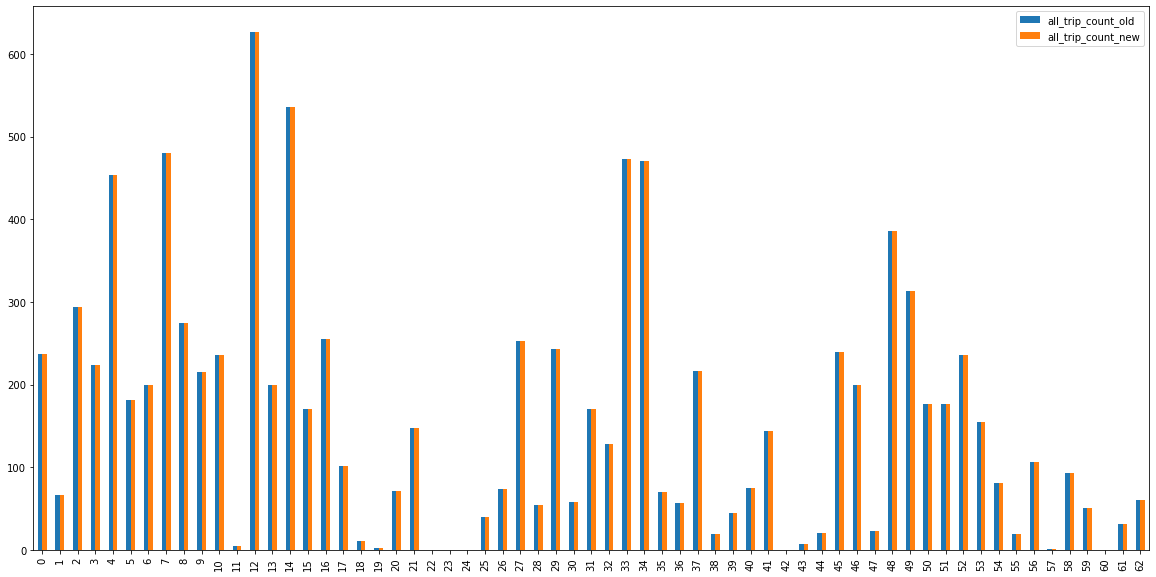

In [20]:
model_validity_stats_df.plot(kind="bar", y=["all_trip_count_old", "all_trip_count_new"],figsize=(20,10))

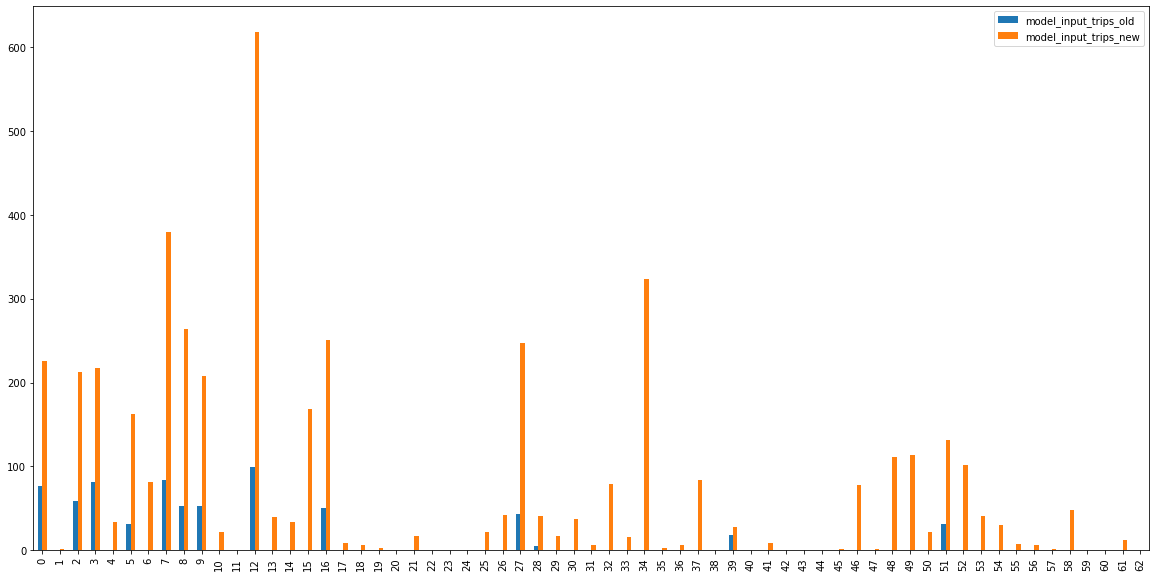

In [21]:
model_validity_stats_df.plot(kind="bar", y=["model_input_trips_old", "model_input_trips_new"],figsize=(20,10))

In [22]:
model_validity_df = pd.DataFrame(model_validity_stats)
model_validity_df[["all_trip_count_old", "unlabeled_trip_count_old", "model_input_trips_old", "model_input_trips_new", "predicted_trips_all_old", "predicted_trips_unlabeled_old", "predicted_trips_all_new", "predicted_trips_unlabeled_new"]]

,all_trip_count_old,unlabeled_trip_count_old,model_input_trips_old,model_input_trips_new,predicted_trips_all_old,predicted_trips_unlabeled_old,predicted_trips_all_new,predicted_trips_unlabeled_new
0,237,11,76,226,99.0,5.0,235,9
1,66,65,0,1,NaN,NaN,16,15
2,294,82,58,212,70.0,7.0,261,49
3,224,7,81,217,108.0,3.0,224,7
4,453,420,0,33,NaN,NaN,189,156
...,...,...,...,...,...,...,...,...
58,93,45,0,48,NaN,NaN,56,8
59,51,51,0,0,NaN,NaN,0,0
60,0,0,0,0,NaN,NaN,0,0
61,31,19,0,12,NaN,NaN,16,4


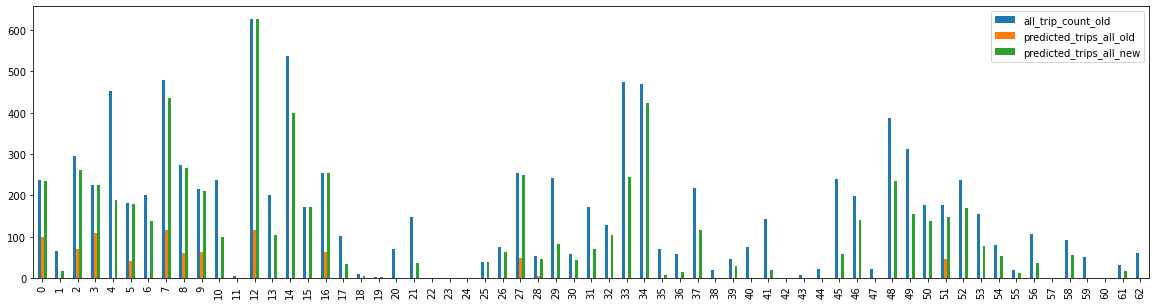

In [23]:
model_validity_df.plot.bar(y=["all_trip_count_old", "predicted_trips_all_old", "predicted_trips_all_new"], figsize=(20,5))

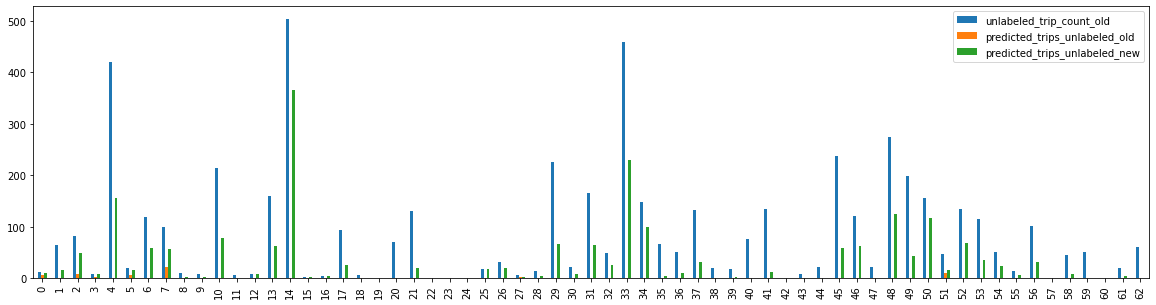

In [24]:
model_validity_df.plot.bar(y=["unlabeled_trip_count_old", "predicted_trips_unlabeled_old", "predicted_trips_unlabeled_new"], figsize=(20,5))

In [25]:
model_validity_df["unlabeled_predict_pct_new"] = model_validity_df.predicted_trips_unlabeled_new/model_validity_df.unlabeled_trip_count_new

In [26]:
model_validity_df["unlabeled_predict_pct_old"] = model_validity_df.predicted_trips_unlabeled_old/model_validity_df.unlabeled_trip_count_old

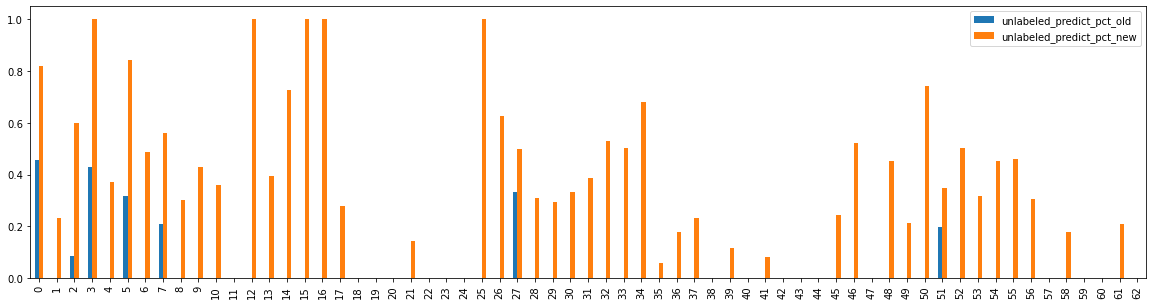

In [27]:
model_validity_df.plot(kind="bar", y=["unlabeled_predict_pct_old", "unlabeled_predict_pct_new"], figsize=(20,5))

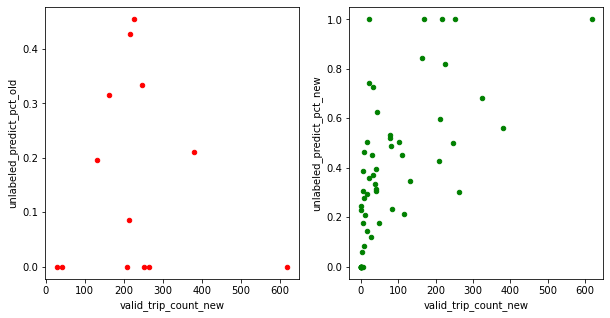

In [28]:

fig = plt.Figure(figsize=(10,5))
axarr = fig.subplots(1,2)
model_validity_df.plot(kind="scatter", x="valid_trip_count_new", y="unlabeled_predict_pct_old", color="red", ax=axarr[0])
model_validity_df.plot(kind="scatter", x="valid_trip_count_new", y="unlabeled_predict_pct_new", color="green", ax=axarr[1])
fig

In [32]:
model_validity_df.query("unlabeled_predict_pct_new < 0.2")[["program", "valid_trip_count_new", "unlabeled_predict_pct_old", "unlabeled_predict_pct_new"]].to_markdown()

'|    | program   |   valid_trip_count_new |   unlabeled_predict_pct_old |   unlabeled_predict_pct_new |\n|---:|:----------|-----------------------:|----------------------------:|----------------------------:|\n| 11 | minipilot |                      0 |                         nan |                   0         |\n| 18 | nrel-lh   |                      6 |                         nan |                   0         |\n| 20 | nrel-lh   |                      0 |                         nan |                   0         |\n| 21 | nrel-lh   |                     17 |                         nan |                   0.145038  |\n| 35 | stage     |                      3 |                         nan |                   0.0597015 |\n| 36 | stage     |                      6 |                         nan |                   0.176471  |\n| 38 | stage     |                      0 |                         nan |                   0         |\n| 39 | stage     |                     28 |           

In [31]:
model_validity_df.query("unlabeled_predict_pct_new < 0.01")[["program", "all_trip_count_new", "unlabeled_trip_count_new", "valid_trip_count_new", "unlabeled_predict_pct_old", "unlabeled_predict_pct_new"]]

,program,all_trip_count_new,unlabeled_trip_count_new,valid_trip_count_new,unlabeled_predict_pct_old,unlabeled_predict_pct_new
11,minipilot,5,5,0,NaN,0.0
18,nrel-lh,11,5,6,NaN,0.0
20,nrel-lh,71,71,0,NaN,0.0
38,stage,20,20,0,NaN,0.0
40,stage,75,75,0,NaN,0.0
43,stage,7,7,0,NaN,0.0
44,stage,21,21,0,NaN,0.0
47,stage,23,22,1,NaN,0.0
59,stage,51,51,0,NaN,0.0
62,stage,60,60,0,NaN,0.0
